In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Step 1: Extract mainshock data from HDF5 file
def extract_mainshock_data(hdf5_file_path):
    mainshock_data = []
    with h5py.File(hdf5_file_path, 'r') as f:
        for mainshock_id in f.keys():
            group = f[mainshock_id]
            magnitude = group.attrs['main_shock_magnitude']
            mainshock_data.append((mainshock_id, magnitude))
    return mainshock_data

# Step 2: Calculate total energy for each mainshock
def calculate_energy(magnitude):
    # Using the empirical formula: log10(E) = 1.5 * magnitude + 4.8
    return 10 ** (1.5 * magnitude + 4.8)

# Step 3: Apply smoothing
def smooth_data(data, sigma=1):
    return gaussian_filter1d(data, sigma)

# Step 4: Create logarithmic plot
def plot_mainshock_energies(mainshock_data, smoothed=True):
    mainshock_ids, magnitudes = zip(*mainshock_data)
    energies = [calculate_energy(mag) for mag in magnitudes]
    
    if smoothed:
        energies = smooth_data(energies)
        
    
    plt.figure(figsize=(12, 6))
    plt.semilogy(range(len(mainshock_ids)), energies, 'bo-')
    plt.xlabel('Mainshock Index')
    plt.ylabel('Total Energy (J) - Log Scale')
    plt.title('Total Energy of Mainshocks (Smoothed)' if smoothed else 'Total Energy of Mainshocks')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


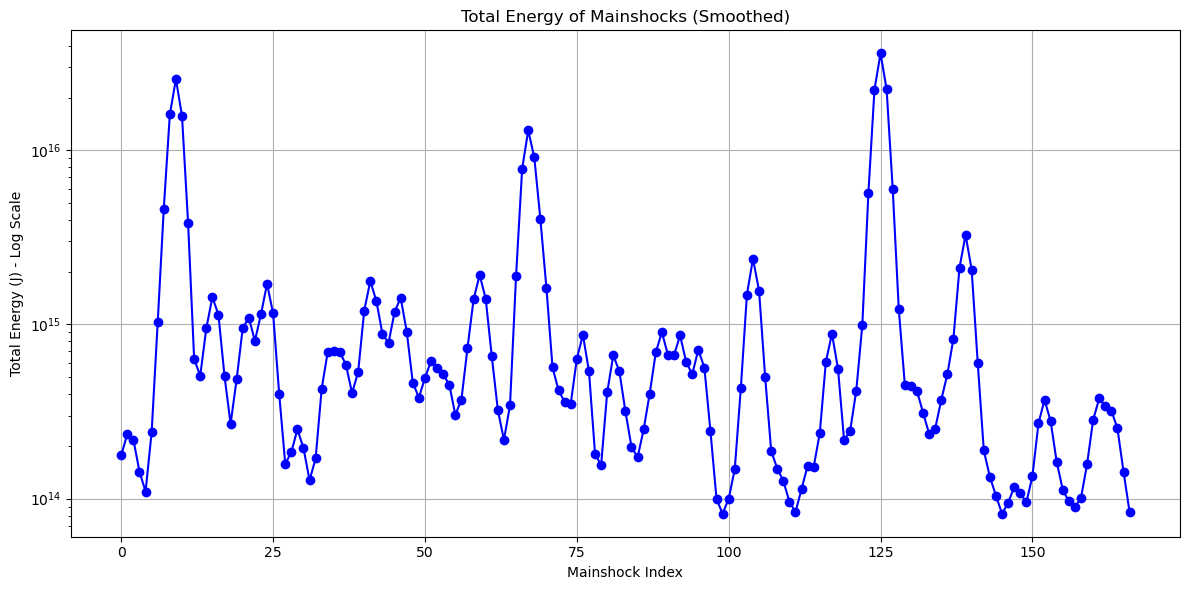

In [2]:

# Main execution
hdf5_file_path = "Data/Displacements_min_mainshock_mag=6_min_stations_per_main_shock=3_regression=True_min_after_shock_mag=2.5_after_shock_time_window=45_n_days_before_mainshock=1_n_days_after_mainshock=1_min_days_between_mainshocks=30_grid_size_km=250.hdf5"  # Replace with your actual file path
mainshock_data = extract_mainshock_data(hdf5_file_path)
plot_mainshock_energies(mainshock_data, smoothed=True)

This script does the following:

 -Extracts mainshock data (ID and magnitude) from the HDF5 file.
 
 -Calculates the total energy for each mainshock using the empirical formula: log10(E) = 1.5 * magnitude + 4.8
 
 -Applies Gaussian smoothing to the energy values.
 
 -Creates a logarithmic plot of the smoothed energy values.

In [6]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def calculate_pixel_energy(interpolated_displacement, pixel_area, crust_thickness=15000, shear_modulus=3e10):
    """
    Calculate the energy for a single pixel.
    
    :param interpolated_displacement: Array of shape (3,) containing x, y, z displacements in mm
    :param pixel_area: Area of the pixel in m^2
    :param crust_thickness: Thickness of the crust in meters (default 15 km)
    :param shear_modulus: Shear modulus of the crust in Pa (default 30 GPa)
    :return: Energy in Joules
    """
    # Convert displacements from mm to m
    displacements = interpolated_displacement[:3] / 1000

    # Calculate strain components (assuming small strain approximation)
    strain_xx = displacements[0] / (np.sqrt(pixel_area) / 2)
    strain_yy = displacements[1] / (np.sqrt(pixel_area) / 2)
    strain_zz = displacements[2] / (crust_thickness / 2)
    
    # Calculate strain energy density (assuming isotropic linear elasticity)
    strain_energy_density = 0.5 * shear_modulus * (strain_xx**2 + strain_yy**2 + strain_zz**2)
    
    # Calculate total energy
    volume = pixel_area * crust_thickness
    energy = strain_energy_density * volume
    
    return energy

def plot_energy_maps(hdf5_file_path, output_dir):
    with h5py.File(hdf5_file_path, 'r') as file:
        for id_seq in file.keys():
            group = file[id_seq]
            interpolated_displacement = group['interpolated_displacement'][()]
            labels = group['labels'][()]
            main_shock_location = group.attrs['main_shock_location']
            main_shock_magnitude = group.attrs['main_shock_magnitude']

            # Calculate pixel area (assuming square pixels)
            cell_size_km = 5  # This should match the cell_size_km used in your interpolation
            pixel_area = (cell_size_km * 1000) ** 2  # Convert to m^2
            
            # Calculate energy map
            energy_map = np.zeros_like(labels)
            for i in range(interpolated_displacement.shape[0]):
                for j in range(interpolated_displacement.shape[1]):
                    if labels[i, j] > 0:  # This pixel contains an aftershock
                        energy = calculate_pixel_energy(interpolated_displacement[i, j], pixel_area)
                        energy_map[i, j] = energy

            # Create figure and axis
            fig, ax = plt.subplots(figsize=(12, 10))

            # Calculate the extent of the plot
            n_pixels_lat, n_pixels_lon = energy_map.shape
            lat_min, lon_min = main_shock_location[0] - (n_pixels_lat/2) * cell_size_km/111, main_shock_location[1] - (n_pixels_lon/2) * cell_size_km/111
            lat_max, lon_max = main_shock_location[0] + (n_pixels_lat/2) * cell_size_km/111, main_shock_location[1] + (n_pixels_lon/2) * cell_size_km/111
            
            # Plot the energy map
            im = ax.imshow(np.log10(energy_map + 1), cmap='viridis', origin='lower', 
                           extent=[lon_min, lon_max, lat_min, lat_max])
            
            # Add colorbar
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            cbar = plt.colorbar(im, cax=cax)
            cbar.set_label('Log10 Energy (J)', rotation=270, labelpad=15)

            # Set title and labels
            ax.set_title(f'Energy Map for Sequence {id_seq}\nMain Shock Magnitude: {main_shock_magnitude:.2f}')
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')

            # Mark the main shock location
            ax.plot(main_shock_location[1], main_shock_location[0], 'r*', markersize=15, label='Main Shock')
            ax.legend()

            # Set appropriate limits for Japan
            ax.set_xlim(130, 145)
            ax.set_ylim(30, 45)

            # Save the figure
            plt.tight_layout()
            plt.savefig(f'{output_dir}/energy_map_sequence_{id_seq}.png', dpi=300, bbox_inches='tight')
            plt.close()

            print(f"Plotted energy map for sequence {id_seq}")
# Usage
hdf5_file_path = "Data/Interpolated_Data_reg=True_soft_labels=True_elasticity=True_min_mainshock_mag=6_min_stations_per_main_shock=3_min_after_shock_mag=4_after_shock_time_window=45_n_days_before_mainshock=1_n_days_after_mainshock=1.hdf5"
output_dir = "Data/energyoutput"
plot_energy_maps(hdf5_file_path, output_dir)

Plotted energy map for sequence 103
Plotted energy map for sequence 109
Plotted energy map for sequence 114
Plotted energy map for sequence 118
Plotted energy map for sequence 151
Plotted energy map for sequence 155
Plotted energy map for sequence 156
Plotted energy map for sequence 158
Plotted energy map for sequence 161
Plotted energy map for sequence 163
Plotted energy map for sequence 172
Plotted energy map for sequence 174
Plotted energy map for sequence 176
Plotted energy map for sequence 179
Plotted energy map for sequence 181
Plotted energy map for sequence 182
Plotted energy map for sequence 187
Plotted energy map for sequence 194
Plotted energy map for sequence 198
Plotted energy map for sequence 199
Plotted energy map for sequence 200
Plotted energy map for sequence 203
Plotted energy map for sequence 204
Plotted energy map for sequence 206
Plotted energy map for sequence 207
Plotted energy map for sequence 213
Plotted energy map for sequence 214
Plotted energy map for seque